In [386]:
import xarray as xr
import cmocean
import matplotlib.pyplot as plt
from dask.diagnostics import ProgressBar
import matplotlib as mpl

In [392]:
experiments = ['piControl','deepmip_sens_1xCO2','deepmip_stand_3xCO2','deepmip_stand_6xCO2','deepmip_sens_9xCO2']
colors = {e:c for e,c in zip(experiments,mpl.colors.TABLEAU_COLORS.keys())}

In [351]:
dso = xr.open_mfdataset('../data/processed/regridded/CESM1.2_CAM5.*.mean.1x1.nc')
dsa = xr.open_mfdataset('../data/processed/regridded/CESM1.2_CAM5.*.mean.3x2.nc')
grido = xr.open_dataset('../data/processed/regridded/grid_1x1_depth.nc')
grida = xr.open_dataset('../data/processed/regridded/grid_3x2_pressure.nc')

In [352]:
dsa

<xarray.Dataset> Size: 161MB
Dimensions:     (experiment: 5, time: 12, y: 90, x: 120, z: 24)
Coordinates:
  * experiment  (experiment) <U19 380B 'deepmip_sens_1xCO2' ... 'piControl'
  * time        (time) int64 96B 0 1 2 3 4 5 6 7 8 9 10 11
  * x           (x) float64 960B 1.5 4.5 7.5 10.5 ... 349.5 352.5 355.5 358.5
  * y           (y) float64 720B -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * z           (z) float64 192B 1e+03 950.0 900.0 850.0 ... 50.0 30.0 20.0 10.0
Data variables: (12/14)
    evspsbl     (experiment, time, y, x) float32 3MB dask.array<chunksize=(5, 12, 90, 120), meta=np.ndarray>
    hfls        (experiment, time, y, x) float32 3MB dask.array<chunksize=(5, 12, 90, 120), meta=np.ndarray>
    hfss        (experiment, time, y, x) float32 3MB dask.array<chunksize=(5, 12, 90, 120), meta=np.ndarray>
    pr          (experiment, time, y, x) float64 5MB dask.array<chunksize=(5, 12, 90, 120), meta=np.ndarray>
    rlds        (experiment, time, y, x) float32 3MB dask.array<chunksize=(5, 12, 90, 120), meta=np.ndarray>
    rlus        (experiment, time, y, x) float32 3MB dask.array<chunksize=(5, 12, 90, 120), meta=np.ndarray>
    ...          ...
    rsdt        (experiment, time, y, x) float32 3MB dask.array<chunksize=(5, 12, 90, 120), meta=np.ndarray>
    rsus        (experiment, time, y, x) float32 3MB dask.array<chunksize=(5, 12, 90, 120), meta=np.ndarray>
    rsut        (experiment, time, y, x) float32 3MB dask.array<chunksize=(5, 12, 90, 120), meta=np.ndarray>
    ta          (experiment, time, z, y, x) float64 124MB dask.array<chunksize=(5, 12, 24, 90, 120), meta=np.ndarray>
    tas         (experiment, time, y, x) float32 3MB dask.array<chunksize=(5, 12, 90, 120), meta=np.ndarray>
    wfno        (experiment, time, y, x) float32 3MB dask.array<chunksize=(5, 12, 90, 120), meta=np.ndarray>

# Ocean heat transport
$$
\mathcal{H}_o = \iint_{x,z} v \rho_0 C_p \theta dx dz
$$

In [482]:
# constants
cp = 4000 # specific heat capacity of water (Jkg-1C-1)
rho0 = 1035 # reference density (kgm-3)
cm2m = 1e-2
W2PW = 1e-15
# heat flux
h = (dso['vo']*cm2m)*ds['thetao']*cp*rho0
# integrated heat flux
Ho = h.weighted(grido['dx']*grido['dz']).sum(['x','z'],skipna=True)*W2PW

In [484]:
with ProgressBar():
    Honow = Ho.mean('time').compute()

[########################################] | 100% Completed | 7.05 ss


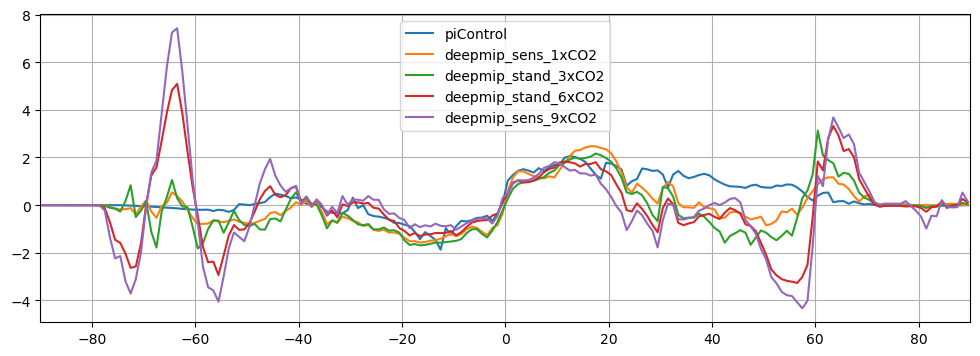

In [486]:
fig,ax = plt.subplots(figsize=(12,4))
for experiment in experiments:
    ax.plot(Hnow['y'],Hnow.sel(experiment=experiment),label=experiment)
ax.set_xlim([-90,90])
ax.grid()
ax.legend()

# Surface ocean heat fluxes
$$
\mathcal{R} = \int_{x} h(x,y)\Delta y\ dx
$$

In [365]:
R = dso['hfno'].weighted((grido['dx']*grido['dy']).fillna(0)).sum(['x'])*W2PW
Ranom = R-R.sel(experiment='deepmip_sens_1xCO2')

In [367]:
with ProgressBar():
    Rnow = R.mean('time').compute()

[########################################] | 100% Completed | 101.95 ms


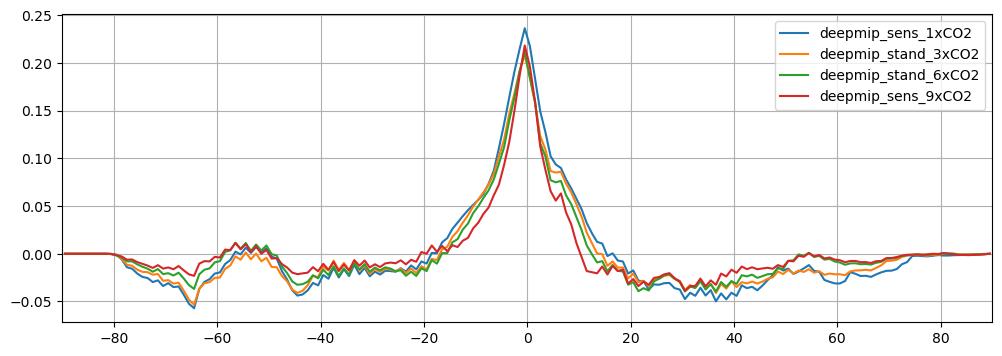

In [369]:
fig,ax = plt.subplots(figsize=(12,4))
for experiment in experiments[1:]:
    ax.plot(Rnow['y'],Rnow.sel(experiment=experiment),label=experiment)
ax.set_xlim([-90,90])
ax.grid()
ax.legend()

# Atmospheric heat transport
$$
\frac{d\mathcal{H}_a}{dy} = R_{TOA} - R_{sfc}
$$

$$
\mathcal{H}_a(y) = \int_{-90}^y (R_{TOA} - R_{sfc}) dy
$$

In [372]:
dsa['sfc'] = dsa['rsds']+dsa['rlds']-dsa['rsus']-dsa['rlus']-dsa['hfls']-dsa['hfss']
dsa['toa'] = dsa['rsdt']-dsa['rsut']-dsa['rlut']

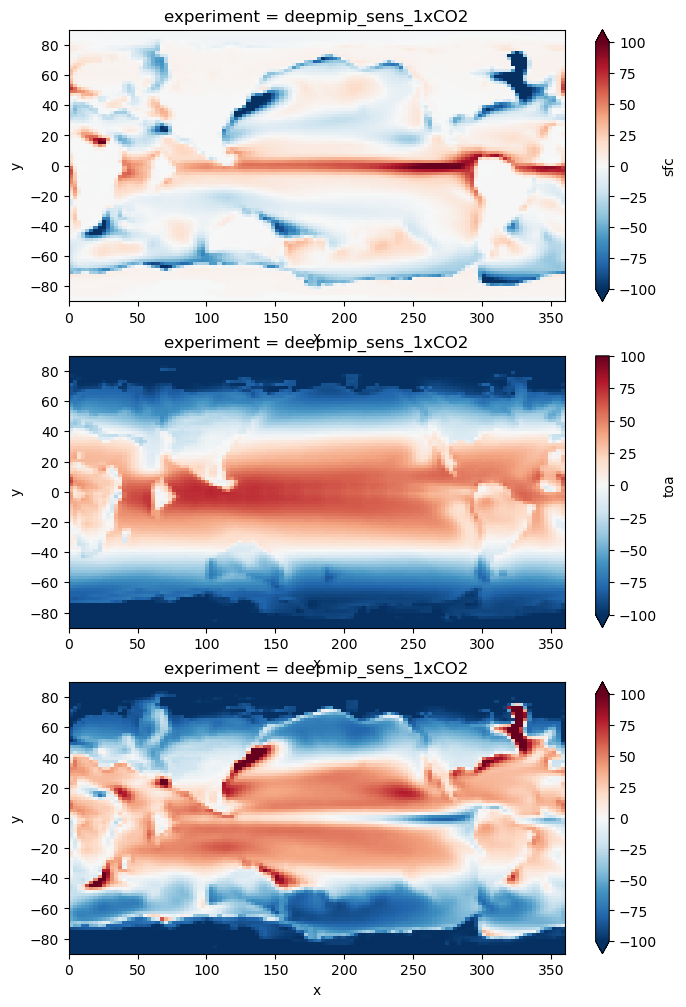

In [374]:
dsnow = dsa.mean('time').isel(experiment=0)
kwargs = {'vmin':-100,'vmax':100,'cmap':'RdBu_r'}
fig, axarr = plt.subplots(figsize=(8,12),nrows=3)
dsnow['sfc'].plot(ax=axarr[0],**kwargs)
dsnow['toa'].plot(ax=axarr[1],**kwargs)
(dsnow['toa']-dsnow['sfc']).plot(ax=axarr[2],**kwargs)

In [476]:
# heat transport divergence
dHady = (dsa['toa'].weighted(grida['dx']).sum('x')-dsa['sfc'].weighted(grida['dx']).sum('x'))
# integrate to get heat transport
dy1d = grida['dy'].isel(x=0).squeeze()
Ha = (dHady*dy1d).cumsum('y')*W2PW
# toa transport divergence (use this to get ocean heat transport)
dHtoady = dsa['toa'].weighted(grida['dx']).sum('x')
Htoa = (dHtoady*dy1d).cumsum('y')*W2PW
Hores = Htoa-Ha

In [520]:
with ProgressBar():
    Hanow = Ha.mean('time').compute()
    Horesnow = Hores.mean('time').compute()

[########################################] | 100% Completed | 103.00 ms
[########################################] | 100% Completed | 106.52 ms


Text(0.5, 1.0, 'Global meridional heat transport by the atmosphere and ocean')

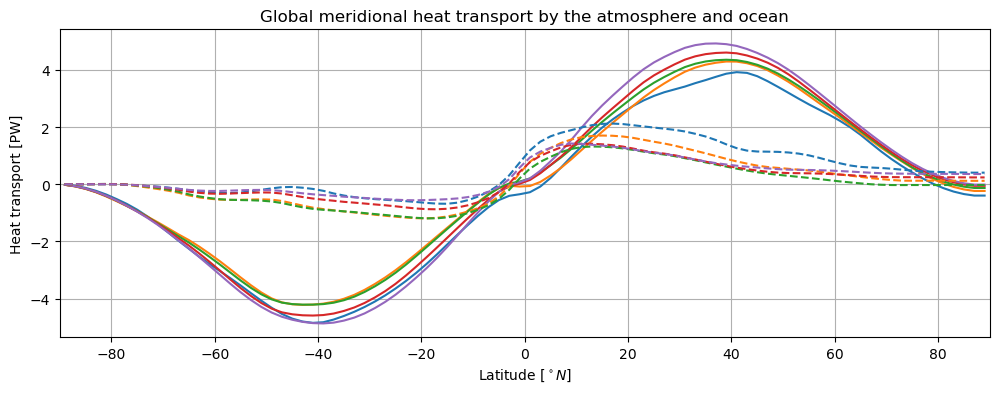

In [524]:
fig,ax = plt.subplots(figsize=(12,4))
for experiment in experiments:
    h = ax.plot(Hanow['y'],Hanow.sel(experiment=experiment),color=colors[experiment],label=experiment)
for experiment in experiments:
    h = ax.plot(Horesnow['y'],Horesnow.sel(experiment=experiment),color=colors[experiment],linestyle='--',label=experiment)
ax.set_xlim([-90,90])
ax.grid()
ax.set_xlabel(r'Latitude [$^\circ N$]')
ax.set_ylabel(r'Heat transport [PW]')
ax.set_title(r'Global meridional heat transport by the atmosphere and ocean')
# ax.legend()

In [488]:
with ProgressBar():
    Hanow = (Ha-Ha.sel(experiment='deepmip_sens_1xCO2')).mean('time').compute()
    Horesnow = (Hores-Hores.sel(experiment='deepmip_sens_1xCO2')).mean('time').compute()
    Honow = (Ho-Ho.sel(experiment='deepmip_sens_1xCO2')).mean('time').compute()

[########################################] | 100% Completed | 107.48 ms
[########################################] | 100% Completed | 106.27 ms
[########################################] | 100% Completed | 6.85 ss


Text(0.5, 1.0, 'Anomaly in heat transport relative to 1xCO2')

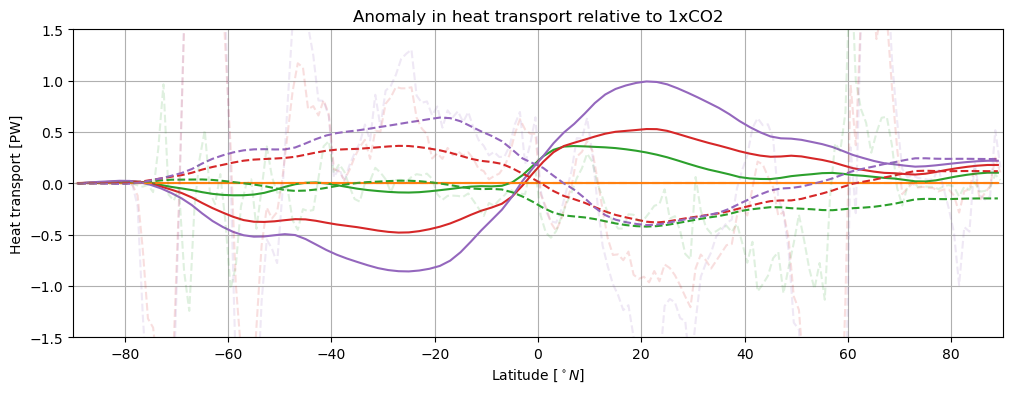

In [516]:
fig,ax = plt.subplots(figsize=(12,4))
for experiment in experiments[1:]:
    h = ax.plot(Hanow['y'],Hanow.sel(experiment=experiment),color=colors[experiment],label=experiment)
for experiment in experiments[1:]:
    h = ax.plot(Horesnow['y'],Horesnow.sel(experiment=experiment),color=colors[experiment],linestyle='--',label=experiment)
for experiment in experiments[1:]:
    h = ax.plot(Honow['y'],Honow.sel(experiment=experiment),color=colors[experiment],linestyle='--',alpha=0.15,label=experiment)
ax.set_xlim([-90,90])
ax.set_ylim([-1.5,1.5])
ax.grid()
ax.set_xlabel(r'Latitude [$^\circ N$]')
ax.set_ylabel(r'Heat transport [PW]')
ax.set_title(r'Anomaly in heat transport relative to 1xCO2')
# ax.legend()

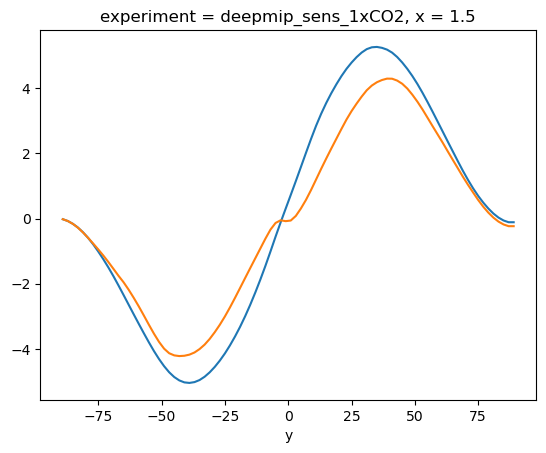

In [434]:
toa = dsa['toa'].weighted(grida['dx']).sum('x')
Htoa = (toa*dy1d).cumsum('y')*W2PW
Htoa.isel(experiment=0).plot()
Hanow.isel(experiment=0).plot()